In [1]:
# Importing necessary libraries
import zipfile
import os
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import time
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import torch.nn as nn

In [2]:
# Zip Extraction
zip_file_path = 'cnn_dataset.zip'
extracted_dir_path = os.path.join(os.path.dirname(zip_file_path), 'cnn_dataset')
os.makedirs(extracted_dir_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)
print("Extraction complete.")

Extraction complete.


# Base Case

## Data Preprocessing

In [54]:
# Transformations
image_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(root='cnn_dataset', transform=image_transformation)

Number of images available:  30000
Number of classes:  3
Class distribution: {0: 10000, 1: 10000, 2: 10000}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


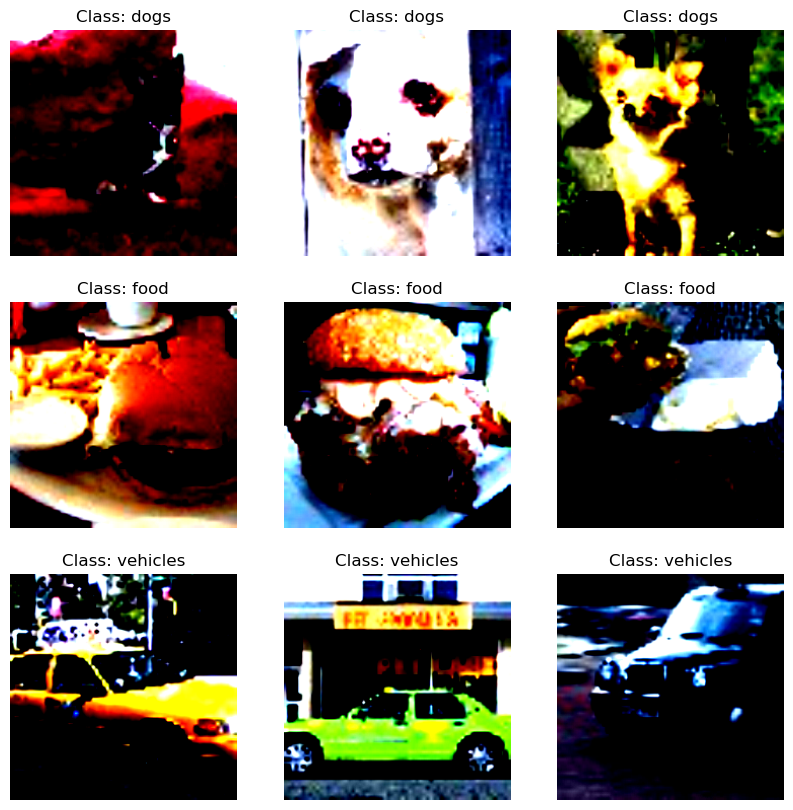

In [55]:
# Dataset Information
print("Number of images available: ", len(image_dataset))
num_classes = len(image_dataset.classes)
print("Number of classes: ", num_classes)

class_distribution = {}
for _, label in image_dataset:
    class_distribution[label] = class_distribution.get(label, 0) + 1
print("Class distribution:", class_distribution)

# Visualization 1(Sample Images)
def show_images(image_dataset, num_samples_per_class=3):
    plt.figure(figsize=(10, 10))
    classes = image_dataset.classes
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, (_, label) in enumerate(image_dataset) if label == i]
        sampled_indices = class_indices[:num_samples_per_class]
        for j, idx in enumerate(sampled_indices):
            image, _ = image_dataset[idx]
            plt.subplot(num_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.title(f"Class: {class_name}")
            plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
            plt.axis('off')
    plt.show()

show_images(image_dataset)

In [56]:
# Convert targets to categorical values
image_dataset.targets = torch.tensor(image_dataset.targets)

# Split dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(image_dataset))
val_size = int(val_ratio * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sizes of each dataset
print("Size of training dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of testing dataset:", len(test_dataset))

# Class
class_counts = {class_name: 0 for class_name in train_dataset.dataset.classes}
for _, label in train_dataset:
    class_counts[train_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

class_counts = {class_name: 0 for class_name in val_dataset.dataset.classes}
for _, label in val_dataset:
    class_counts[val_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of validation dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

class_counts = {class_name: 0 for class_name in test_dataset.dataset.classes}
for _, label in test_dataset:
    class_counts[test_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of testing dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Size of training dataset: 21000
Size of validation dataset: 4500
Size of testing dataset: 4500

Class-wise size of training dataset:
dogs: 6994
food: 7009
vehicles: 6997

Class-wise size of validation dataset:
dogs: 1500
food: 1508
vehicles: 1492

Class-wise size of testing dataset:
dogs: 1506
food: 1483
vehicles: 1511


## VGG13 Architecture

In [57]:
# Define the VGG13 model
class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = VGG13(num_classes)
print(model)

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [59]:
# Define Regularization(optimizer), loss function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 1

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_time = time.time()
        if current_time - start_time >= 50: 
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")
            start_time = current_time 

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    # Validation of model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1/1, Total images trained: 192, Training Accuracy: 36.46%
Epoch 1/1, Total images trained: 384, Training Accuracy: 32.55%
Epoch 1/1, Total images trained: 576, Training Accuracy: 32.47%
Epoch 1/1, Total images trained: 768, Training Accuracy: 33.85%
Epoch 1/1, Total images trained: 960, Training Accuracy: 31.88%
Epoch 1/1, Total images trained: 1152, Training Accuracy: 32.81%
Epoch 1/1, Total images trained: 1344, Training Accuracy: 33.93%
Epoch 1/1, Total images trained: 1536, Training Accuracy: 34.90%
Epoch 1/1, Total images trained: 1728, Training Accuracy: 34.66%
Epoch 1/1, Total images trained: 1920, Training Accuracy: 34.27%
Epoch 1/1, Total images trained: 2112, Training Accuracy: 34.28%
Epoch 1/1, Total images trained: 2304, Training Accuracy: 34.29%
Epoch 1/1, Total images trained: 2496, Training Accuracy: 34.13%
Epoch 1/1, Total images trained: 2688, Training Accuracy: 33.59%
Epoch 1/1, Total images trained: 2880, Training Accuracy: 33.65%
Epoch 1/1, Total images traine

In [60]:
# Testing loop
correct_test = 0
total_test = 0
test_loss = 0.0 

model.eval()  
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        # Calculate test loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
test_accuracy = correct_test / total_test
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 77.78%
Test Loss: 0.5666


In [61]:
# Confusion matrix  
# Precision, recall, and F1 score
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)


precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print("Confusion Matrix:")
print(conf_matrix)

print("\nEvaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Confusion Matrix:
[[1130  358   18]
 [ 135 1330   18]
 [ 294  177 1040]]

Evaluation Metrics:
Precision: 0.8021
Recall: 0.7778
F1 Score: 0.7786


# Base Case + Regularization

## Data Preprocessing

In [28]:
# Transformation
image_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(root='cnn_dataset', transform=image_transformation)

Number of images available:  30000
Number of classes:  3
Class distribution: {0: 10000, 1: 10000, 2: 10000}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


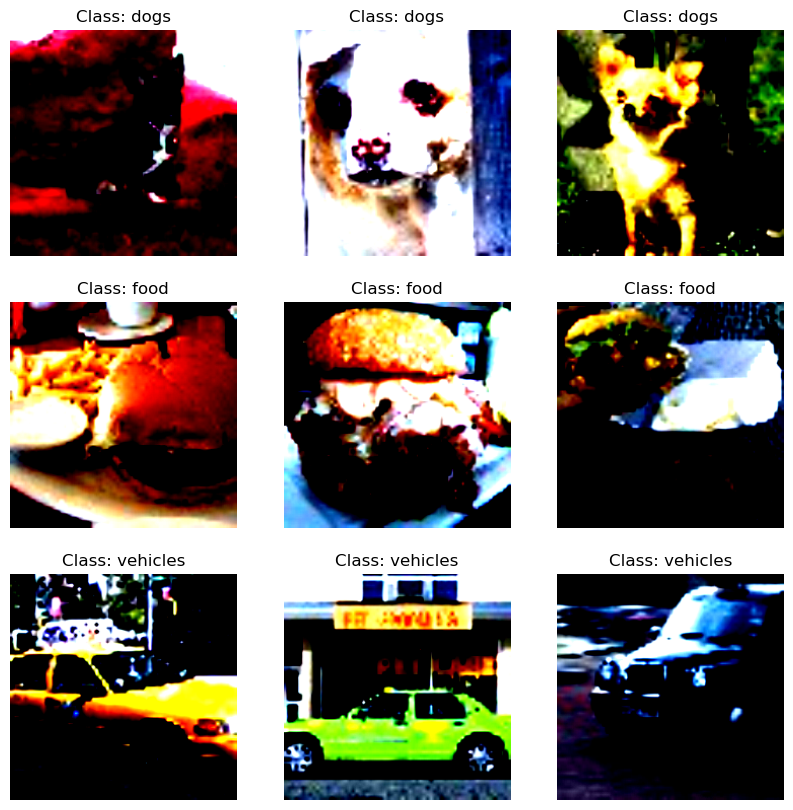

In [29]:
# Dataset Information
print("Number of images available: ", len(image_dataset))
num_classes = len(image_dataset.classes)
print("Number of classes: ", num_classes)

class_distribution = {}
for _, label in image_dataset:
    class_distribution[label] = class_distribution.get(label, 0) + 1
print("Class distribution:", class_distribution)

# Visualization 1(Sample Images)
def show_images(image_dataset, num_samples_per_class=3):
    plt.figure(figsize=(10, 10))
    classes = image_dataset.classes
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, (_, label) in enumerate(image_dataset) if label == i]
        sampled_indices = class_indices[:num_samples_per_class]
        for j, idx in enumerate(sampled_indices):
            image, _ = image_dataset[idx]
            plt.subplot(num_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.title(f"Class: {class_name}")
            plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
            plt.axis('off')
    plt.show()

show_images(image_dataset)

In [30]:
# Convert targets to categorical values
image_dataset.targets = torch.tensor(image_dataset.targets)

# Split dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(image_dataset))
val_size = int(val_ratio * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sizes of each dataset
print("Size of training dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of testing dataset:", len(test_dataset))

class_counts = {class_name: 0 for class_name in train_dataset.dataset.classes}
for _, label in train_dataset:
    class_counts[train_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

class_counts = {class_name: 0 for class_name in val_dataset.dataset.classes}
for _, label in val_dataset:
    class_counts[val_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of validation dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

class_counts = {class_name: 0 for class_name in test_dataset.dataset.classes}
for _, label in test_dataset:
    class_counts[test_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of testing dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Size of training dataset: 21000
Size of validation dataset: 4500
Size of testing dataset: 4500

Class-wise size of training dataset:
dogs: 7051
food: 6979
vehicles: 6970

Class-wise size of validation dataset:
dogs: 1490
food: 1485
vehicles: 1525

Class-wise size of testing dataset:
dogs: 1459
food: 1536
vehicles: 1505


## VGG13 Architecture

In [31]:
# VGG13 Architecture
class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

num_classes = 3
model = VGG13(num_classes)
print(model)

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [33]:
# Define Regularization(optimizer), loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Train the model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 1
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for batch_idx, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_time = time.time()
        if current_time - start_time >= 50:
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")
            start_time = current_time

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    # Validation of model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1/1, Total images trained: 192, Training Accuracy: 28.65%
Epoch 1/1, Total images trained: 384, Training Accuracy: 33.33%
Epoch 1/1, Total images trained: 576, Training Accuracy: 33.51%
Epoch 1/1, Total images trained: 768, Training Accuracy: 33.20%
Epoch 1/1, Total images trained: 960, Training Accuracy: 32.60%
Epoch 1/1, Total images trained: 1152, Training Accuracy: 31.60%
Epoch 1/1, Total images trained: 1344, Training Accuracy: 31.85%
Epoch 1/1, Total images trained: 1536, Training Accuracy: 32.68%
Epoch 1/1, Total images trained: 1728, Training Accuracy: 33.22%
Epoch 1/1, Total images trained: 1920, Training Accuracy: 33.18%
Epoch 1/1, Total images trained: 2112, Training Accuracy: 33.43%
Epoch 1/1, Total images trained: 2304, Training Accuracy: 33.94%
Epoch 1/1, Total images trained: 2496, Training Accuracy: 33.93%
Epoch 1/1, Total images trained: 2688, Training Accuracy: 33.97%
Epoch 1/1, Total images trained: 2880, Training Accuracy: 33.61%
Epoch 1/1, Total images traine

In [34]:
# Testing loop
correct_test = 0
total_test = 0
test_loss = 0.0

model.eval() 
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 78.51%
Test Loss: 0.5435


In [35]:
# Confusion matrix  
# Precision, recall, and F1 score
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)


precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print("Confusion Matrix:")
print(conf_matrix)

print("\nEvaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Confusion Matrix:
[[1024  372   63]
 [ 180 1324   32]
 [ 166  154 1185]]

Evaluation Metrics:
Precision: 0.7962
Recall: 0.7851
F1 Score: 0.7863


# Base Case + Regularization + Dropout + Early Stooping

## Data Preprocessing

In [20]:
# # Transformations
image_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(root='cnn_dataset', transform=image_transformation)

Number of images available:  30000
Number of classes:  3
Class distribution: {0: 10000, 1: 10000, 2: 10000}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


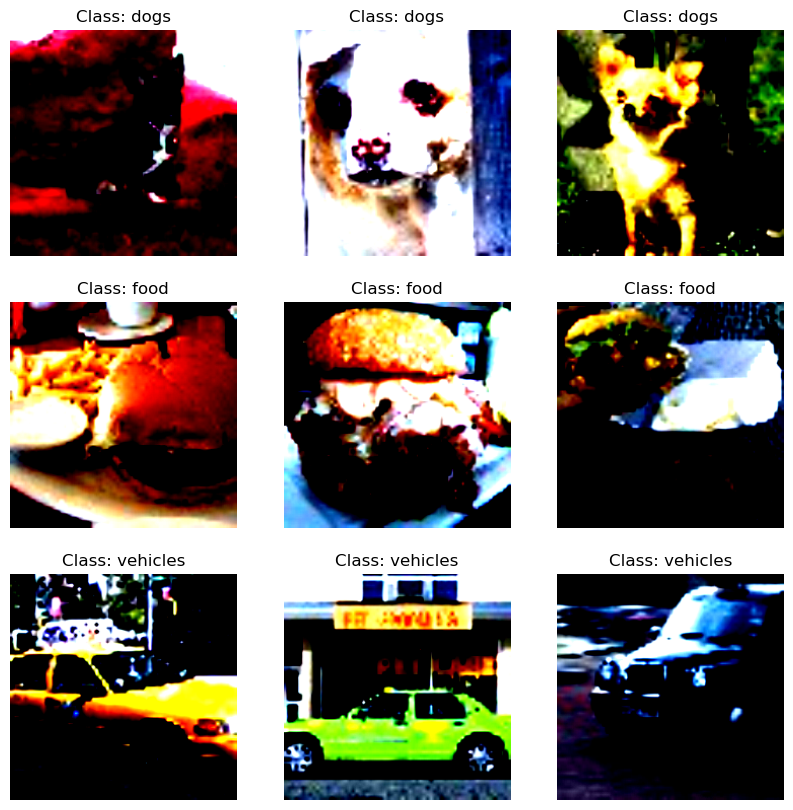

In [21]:
# Dataset Information
print("Number of images available: ", len(image_dataset))
num_classes = len(image_dataset.classes)
print("Number of classes: ", num_classes)

class_distribution = {}
for _, label in image_dataset:
    class_distribution[label] = class_distribution.get(label, 0) + 1
print("Class distribution:", class_distribution)

# Visualization 1(Sample Images)
def show_images(image_dataset, num_samples_per_class=3):
    plt.figure(figsize=(10, 10))
    classes = image_dataset.classes
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, (_, label) in enumerate(image_dataset) if label == i]
        sampled_indices = class_indices[:num_samples_per_class]
        for j, idx in enumerate(sampled_indices):
            image, _ = image_dataset[idx]
            plt.subplot(num_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.title(f"Class: {class_name}")
            plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
            plt.axis('off')
    plt.show()
show_images(image_dataset)

# Convert targets to categorical values
image_dataset.targets = torch.tensor(image_dataset.targets)

In [22]:
# Split dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(image_dataset))
val_size = int(val_ratio * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sizes of each dataset
print("Size of training dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of testing dataset:", len(test_dataset))

class_counts = {class_name: 0 for class_name in train_dataset.dataset.classes}
for _, label in train_dataset:
    class_counts[train_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

class_counts = {class_name: 0 for class_name in val_dataset.dataset.classes}
for _, label in val_dataset:
    class_counts[val_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of validation dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

class_counts = {class_name: 0 for class_name in test_dataset.dataset.classes}
for _, label in test_dataset:
    class_counts[test_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of testing dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Size of training dataset: 21000
Size of validation dataset: 4500
Size of testing dataset: 4500

Class-wise size of training dataset:
dogs: 6994
food: 7042
vehicles: 6964

Class-wise size of validation dataset:
dogs: 1482
food: 1498
vehicles: 1520

Class-wise size of testing dataset:
dogs: 1524
food: 1460
vehicles: 1516


## VGG13 Architecture

In [23]:
# VGG13 Architecture
class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = VGG13(num_classes)
print(model)

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [25]:
# Define Regularization(optimizer), loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.3, verbose=True)

# Train the model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 1
best_val_loss = float('inf')
patience = 0

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_time = time.time()
        if current_time - start_time >= 50:
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")
            start_time = current_time

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    # Validation of model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience += 1
        if patience > 2:
            print("Early stopping.")
            break

    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1/1, Total images trained: 192, Training Accuracy: 34.38%
Epoch 1/1, Total images trained: 384, Training Accuracy: 32.29%
Epoch 1/1, Total images trained: 576, Training Accuracy: 29.86%
Epoch 1/1, Total images trained: 768, Training Accuracy: 31.51%
Epoch 1/1, Total images trained: 960, Training Accuracy: 32.40%
Epoch 1/1, Total images trained: 1152, Training Accuracy: 32.38%
Epoch 1/1, Total images trained: 1344, Training Accuracy: 32.81%
Epoch 1/1, Total images trained: 1536, Training Accuracy: 33.27%
Epoch 1/1, Total images trained: 1728, Training Accuracy: 34.09%
Epoch 1/1, Total images trained: 1920, Training Accuracy: 36.20%
Epoch 1/1, Total images trained: 2112, Training Accuracy: 36.70%
Epoch 1/1, Total images trained: 2304, Training Accuracy: 37.02%
Epoch 1/1, Total images trained: 2496, Training Accuracy: 37.86%
Epoch 1/1, Total images trained: 2688, Training Accuracy: 39.06%
Epoch 1/1, Total images trained: 2880, Training Accuracy: 39.58%
Epoch 1/1, Total images traine

## Results

In [26]:
# Testing loop
correct_test = 0
total_test = 0
test_loss = 0.0

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)

test_accuracy = correct_test / total_test
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 82.00%
Test Loss: 0.4760


In [27]:
# Confusion matrix  
# Precision, recall, and F1 score
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())

conf_matrix = confusion_matrix(true_labels, predicted_labels)


precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print("Confusion Matrix:")
print(conf_matrix)

print("\nEvaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Confusion Matrix:
[[1147  143  234]
 [ 211 1127  122]
 [  40   60 1416]]

Evaluation Metrics:
Precision: 0.8220
Recall: 0.8200
F1 Score: 0.8182
